In [1]:
%matplotlib inline
import numpy as np
import re
import matplotlib.pyplot as plt
import itertools

### puzzle 1 ###

Each particle feels a constant acceleration. Effectively, it's a multi-particle space simulation where each particle has thrust, but nothing can turn (and no mass is lost).

Note that the equation of motion is not the familiar continuous-time

$$
\vec{r}(t) = \vec{r}_0 + \vec{v}_0 \cdot t + \frac{1}{2} \vec{a}_0 \cdot t^2,
$$
but instead
$$
\vec{r}_j = \vec{r}_0 + \vec{v}_0 \cdot j + \frac{j(j-1)}{2} \vec{a}_0 ,
$$
where $j \equiv t/\delta t$.

In [2]:
class Particle(object):
    def __init__(self, r0, v0, a0):
        self.r0 = r0
        self.v0 = v0
        self.a0 = a0
        self.r = r0
        self.v = v0
        self.t = 0
    def step(self):
        self.v += self.a0
        self.r += self.v
        self.t += 1
    def dist(self, j):
        # taxicab distance from origin
        return sum(abs(ri) for ri in self.pos(j))
    def pos(self, j):
        return self.r0 + j*self.v0 + (j*(j-1)/2)*self.a0
    def ataxi(self):
        return sum(abs(ai) for ai in self.a0)

In [3]:
test_input = '''p=< 3,0,0>, v=< 2,0,0>, a=<-1,0,0>
p=< 4,0,0>, v=< 0,0,0>, a=<-2,0,0>'''.split('\n')

In [4]:
test_input

['p=< 3,0,0>, v=< 2,0,0>, a=<-1,0,0>', 'p=< 4,0,0>, v=< 0,0,0>, a=<-2,0,0>']

In [5]:
regex = re.compile(r'<[- \d,]+>')
def construct_particles(data):
    particles = []
    for line in data:
        pstr, vstr, astr = regex.findall(line)
        rx, ry, rz = pstr[1:-1].split(',')
        r = np.array([int(rx), int(ry), int(rz)])
        vx, vy, vz = vstr[1:-1].split(',')
        v = np.array([int(vx), int(vy), int(vz)])
        ax, ay, az = astr[1:-1].split(',')
        a = np.array([int(ax), int(ay), int(az)])
        particles.append(Particle(r, v, a))  
    return particles

In [6]:
particles = construct_particles(test_input)

Closest particle will be the particle with the smallest taxicab accel

In [7]:
accels = np.array([p.ataxi() for p in particles])
print(accels)
print(accels.argmin())

[1 2]
0


In [8]:
puzzle_input = open('day20_input').read().split('\n')[:-1]
puzzle_particles = construct_particles(puzzle_input)
puzzle_accels = np.array([p.ataxi() for p in puzzle_particles])

In [9]:
puzzle_accels.min()

2

In [10]:
wimpiest = [i for i, ataxi in enumerate(puzzle_accels) if ataxi == 2.0]
wimpiest

[47, 161, 464]

Three particles have the lowest acceleration. Which one moves away the slowest depends on the actual trajectory. Simplest to just plot each particle as a function of time.

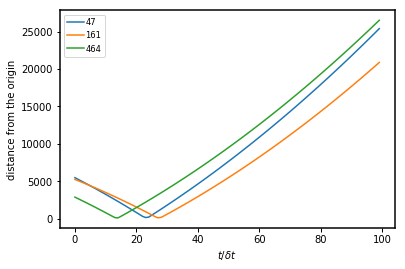

In [11]:
times = list(range(100))
d47 = [puzzle_particles[47].dist(j) for j in times]
d161 = [puzzle_particles[161].dist(j) for j in times]
d464 = [puzzle_particles[464].dist(j) for j in times]
plt.plot(times, d47, '-', label='47')
plt.plot(times, d161, '-', label='161')
plt.plot(times, d464, '-', label='464')
plt.xlabel('$t/\delta t$')
plt.ylabel('distance from the origin')
plt.legend()

### puzzle 2 ###

If two particles collide, they are both destroyed. How many particles survive?

Note that the collision time can be computed as the root of a quadratic (set of) equation(s):

$$
\left(\vec{r}_{\alpha,0} - \vec{r}_{\beta,0}\right) + \left[(\vec{v}_{\alpha,0} - \vec{v}_{\beta,0}) - \frac{1}{2}(\vec{a}_{\alpha,0} - \vec{a}_{\beta,0})\right] \cdot j + \frac{1}{2}\left(\vec{a}_{\alpha,0} - \vec{a}_{\beta,0}\right)\cdot j^2 = 0
$$

In [12]:
test_data = '''p=<-6,0,0>, v=< 3,0,0>, a=< 0,0,0>    
p=<-4,0,0>, v=< 2,0,0>, a=< 0,0,0>
p=<-2,0,0>, v=< 1,0,0>, a=< 0,0,0>
p=< 3,0,0>, v=<-1,0,0>, a=< 0,0,0>'''.split('\n')
test_particles = construct_particles(test_data)

In [13]:
def does_collide(i,j, particles):
    pi = particles[i]
    pj = particles[j]
    delr = pi.r0 - pj.r0
    delv = pi.v0 - pj.v0
    dela = pi.a0 - pj.a0
    for mu in 0,1,2:
        roots = np.roots([0.5*dela[mu], delv[mu]-0.5*dela[mu], delr[mu]])
        for root in roots:
            if np.isreal(root):
                if root >= 0:
                    if root == int(root):
                        print(i, j, mu, root)
                        if all(pi.pos(root) == pj.pos(root)):
                            return True
    return False

In [14]:
num_particles = len(test_particles)
collided = []
for i in range(num_particles):
    for j in range(i+1, num_particles):
        if does_collide(i,j, test_particles):
            collided.append(i)
            collided.append(j)
collided = set(collided)
print(num_particles - len(collided))

0 1 0 2.0
0 2 0 2.0
1 2 0 2.0
1


For some reason the above didn't work with the puzzle input, and the need to remove particles once they've collided adds extra complexity. Perhaps I should just propagate all of the particles:

In [15]:
particles = test_particles.copy()
for t in range(1, 5):
    print('t = {}'.format(t))
    collided_at_t = []
    for p in particles:
        p.step()
    for pi, pj in itertools.combinations(particles, 2):
        print(pi.r, pj.r)
        if np.array_equal(pi.r, pj.r):
            collided_at_t.append(pi)
            collided_at_t.append(pj)
    particles = [p for p in particles if p not in set(collided_at_t)]
print(len(particles))

t = 1
[-3  0  0] [-2  0  0]
[-3  0  0] [-1  0  0]
[-3  0  0] [2 0 0]
[-2  0  0] [-1  0  0]
[-2  0  0] [2 0 0]
[-1  0  0] [2 0 0]
t = 2
[0 0 0] [0 0 0]
[0 0 0] [0 0 0]
[0 0 0] [1 0 0]
[0 0 0] [0 0 0]
[0 0 0] [1 0 0]
[0 0 0] [1 0 0]
t = 3
t = 4
1


In [16]:
particles = puzzle_particles.copy()
for t in range(1, 200):
    collided_at_t = []
    for p in particles:
        p.step()
    for pi, pj in itertools.combinations(particles, 2):
        if np.array_equal(pi.r, pj.r):
            collided_at_t.append(pi)
            collided_at_t.append(pj)
    if collided_at_t:
        print('{} particles in collision'.format(len(set(collided_at_t))))
    particles = [p for p in particles if p not in set(collided_at_t)]
    print('t= {}, particles = {}'.format(t,len(particles)))


t= 1, particles = 1000
t= 2, particles = 1000
t= 3, particles = 1000
t= 4, particles = 1000
t= 5, particles = 1000
t= 6, particles = 1000
t= 7, particles = 1000
t= 8, particles = 1000
t= 9, particles = 1000
5 particles in collision
t= 10, particles = 995
20 particles in collision
t= 11, particles = 975
2 particles in collision
t= 12, particles = 973
24 particles in collision
t= 13, particles = 949
3 particles in collision
t= 14, particles = 946
16 particles in collision
t= 15, particles = 930
26 particles in collision
t= 16, particles = 904
40 particles in collision
t= 17, particles = 864
19 particles in collision
t= 18, particles = 845
45 particles in collision
t= 19, particles = 800
33 particles in collision
t= 20, particles = 767
50 particles in collision
t= 21, particles = 717
25 particles in collision
t= 22, particles = 692
15 particles in collision
t= 23, particles = 677
27 particles in collision
t= 24, particles = 650
26 particles in collision
t= 25, particles = 624
23 particles